##### Imports

In [1]:
import pyspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, date
from pyspark.sql import SparkSession, Row, Column
from pyspark.sql.window import Window
from pyspark.sql.functions import col, avg, count, explode, split, upper, expr, collect_list, size, split, year, row_number, mean, floor, concat_ws, lit

In [66]:
# spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder \
    .appName("ConsultaPySpark") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

business_path = "data/yelp_academic_dataset_business.json"
review_path = "data/yelp_academic_dataset_review.json"

df_business = spark.read.json(business_path)
df_review = spark.read.json(review_path)

##### 1. Obtener los 10 negocios con mayor número de revisiones (2%)


In [3]:
top_businesses = df_review.groupBy("business_id").agg(count("review_id").alias("num_reviews")) \
    .orderBy(col("num_reviews").desc()).limit(10)

result1 = top_businesses.join(df_business, "business_id").select("name", "num_reviews").orderBy(col("num_reviews").desc())
result1.show()


+--------------------+-----------+
|                name|num_reviews|
+--------------------+-----------+
|   Acme Oyster House|       7673|
|        Oceana Grill|       7516|
|Hattie B’s Hot Ch...|       6160|
|Reading Terminal ...|       5778|
|Ruby Slipper - Ne...|       5264|
| Mother's Restaurant|       5254|
|         Royal House|       5146|
|  Commander's Palace|       4969|
|                Luke|       4661|
|              Cochon|       4480|
+--------------------+-----------+



/tmp/ipykernel_13617/883588996.py:8: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="num_reviews", y="name", data=result1_pd, palette="viridis")


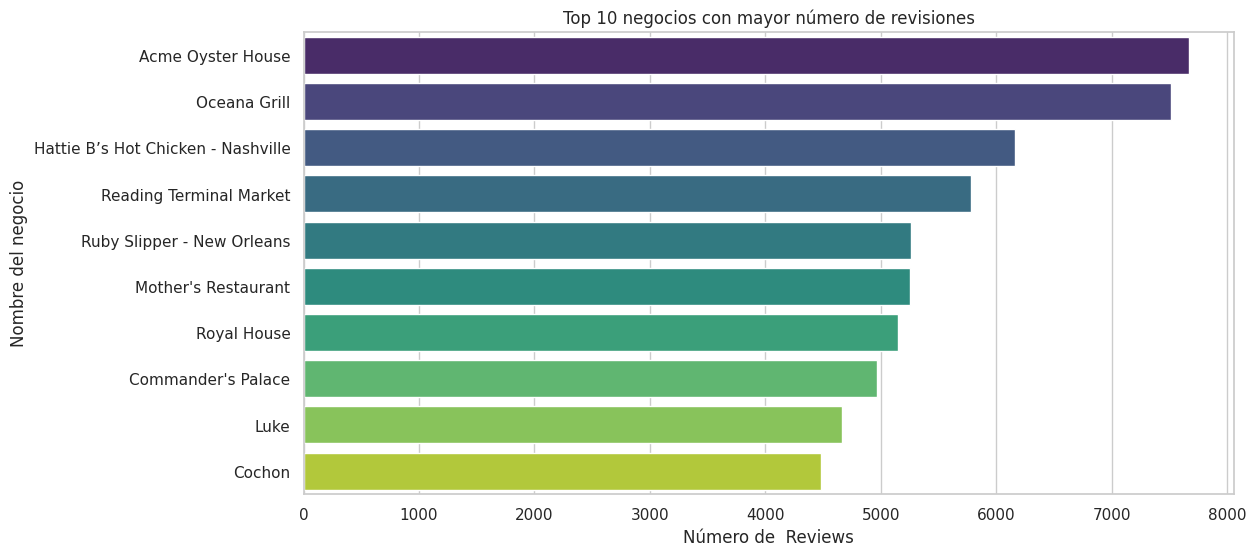

In [4]:
result1_pd = result1.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="num_reviews", y="name", data=result1_pd, palette="viridis")
plt.title("Top 10 negocios con mayor número de revisiones")
plt.xlabel("Número de  Reviews")
plt.ylabel("Nombre del negocio")
plt.show()

##### 2. Obtener las 10 categorías con la mayor puntuación media (2%)


In [5]:
avg_stars_by_category = df_business.select("business_id", "stars", "categories") \
    .withColumn("category", explode(split(col("categories"), ", "))) \
    .groupBy("category").agg(avg("stars").alias("avg_stars")) \
    .orderBy(col("avg_stars").desc()).limit(10) \
    .orderBy(col("category"))

result2 = avg_stars_by_category.show()


+--------------------+---------+
|            category|avg_stars|
+--------------------+---------+
|     Art Consultants|      5.0|
|         Calligraphy|      5.0|
|Cheese Tasting Cl...|      5.0|
|       Childproofing|      5.0|
|         Experiences|      5.0|
|          Patent Law|      5.0|
|        Silent Disco|      5.0|
|              Somali|      5.0|
|Sport Equipment Hire|      5.0|
|     Water Suppliers|      5.0|
+--------------------+---------+



/tmp/ipykernel_13617/1417152152.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_stars", y="category", data=avg_stars_by_category_pd, palette="viridis")


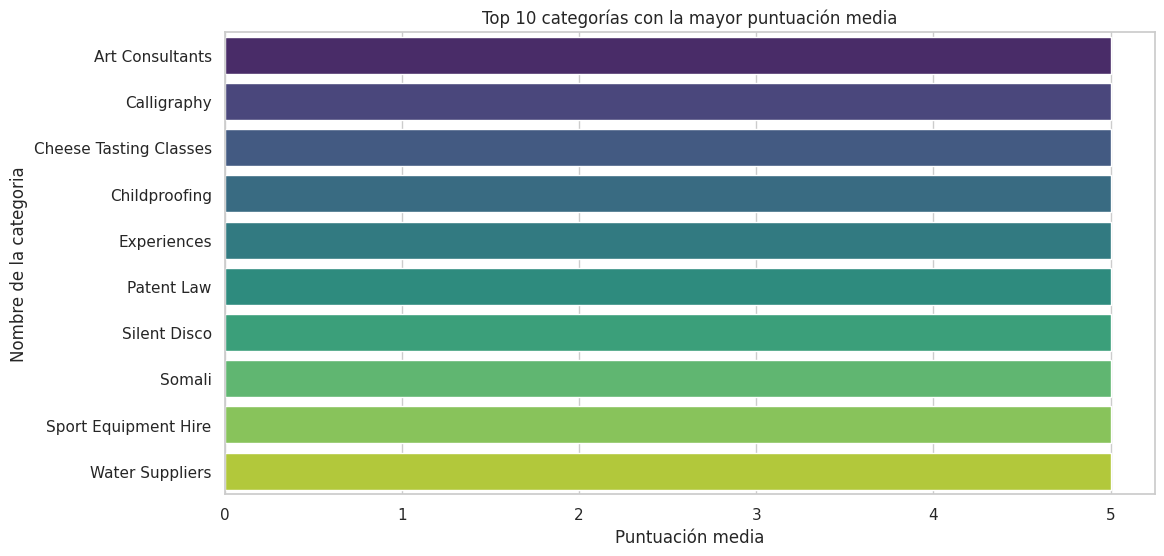

In [6]:
avg_stars_by_category_pd = avg_stars_by_category.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="avg_stars", y="category", data=avg_stars_by_category_pd, palette="viridis")
plt.title("Top 10 categorías con la mayor puntuación media")
plt.xlabel("Puntuación media")
plt.ylabel("Nombre de la categoria")
plt.show()

##### 3. Obtener las 10 ciudades con la mayor puntuación media (2%)


In [7]:
avg_stars_by_city = df_business.select("city", "stars") \
    .groupBy("city").agg(avg("stars").alias("avg_stars")) \
    .orderBy(col("avg_stars").desc()).limit(10) \
    .orderBy(col("city"))

result3 = avg_stars_by_city.show()


+----------------+---------+
|            city|avg_stars|
+----------------+---------+
|         Arizona|      5.0|
| Delaware County|      5.0|
|         Fernley|      5.0|
|        Norriton|      5.0|
|   Pass-a-Grille|      5.0|
|           Reno |      5.0|
|Rosewood Heights|      5.0|
|          SPARKS|      5.0|
|    Webster Grvs|      5.0|
|    phoenixville|      5.0|
+----------------+---------+



/tmp/ipykernel_13617/558502135.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_stars", y="category", data=avg_stars_by_city, palette="viridis")


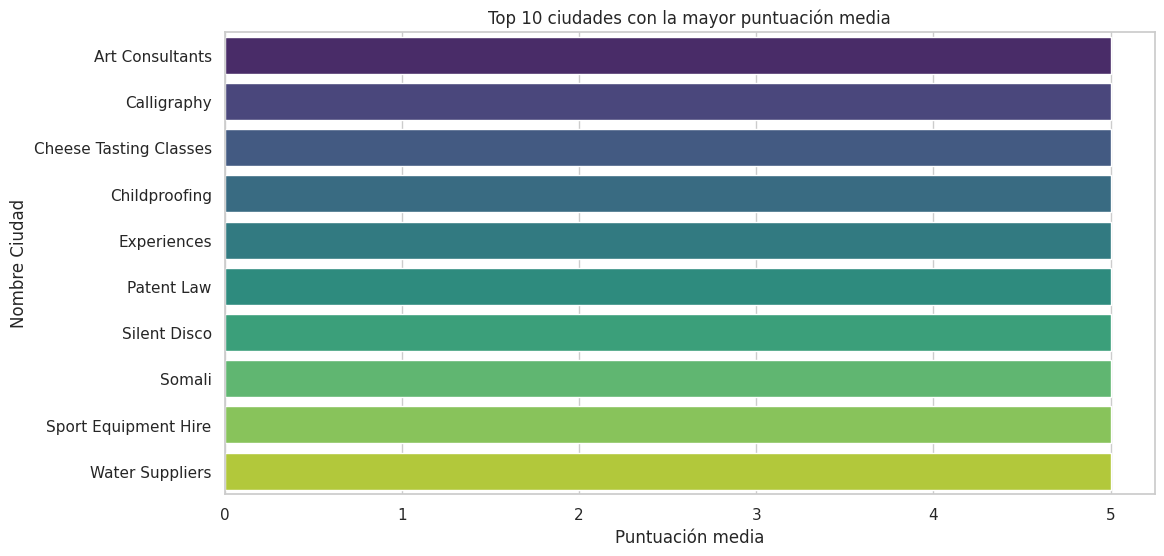

In [8]:
avg_stars_by_city = avg_stars_by_category.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="avg_stars", y="category", data=avg_stars_by_city, palette="viridis")
plt.title("Top 10 ciudades con la mayor puntuación media")
plt.xlabel("Puntuación media")
plt.ylabel("Nombre Ciudad")
plt.show()

##### 4. Calcular la media de palabras para las reseñas de cada puntuación (1-5 estrellas) (2%)


In [9]:
# Calcular la media de palabras para las reseñas de cada puntuación (1-5 estrellas)
avg_words_by_stars = df_review.groupBy("stars").agg(avg(size(split(col("text"), " "))).alias("avg_words")).orderBy(col("stars"))

result4 = avg_words_by_stars.show()


+-----+------------------+
|stars|         avg_words|
+-----+------------------+
|  1.0| 135.3761664832581|
|  2.0|135.76835403498455|
|  3.0|125.33368066896554|
|  4.0|109.01844357355336|
|  5.0| 85.32756936366728|
+-----+------------------+



/tmp/ipykernel_13617/395357095.py:8: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="stars", y="avg_words", data=avg_words_by_stars_pd, palette="viridis")


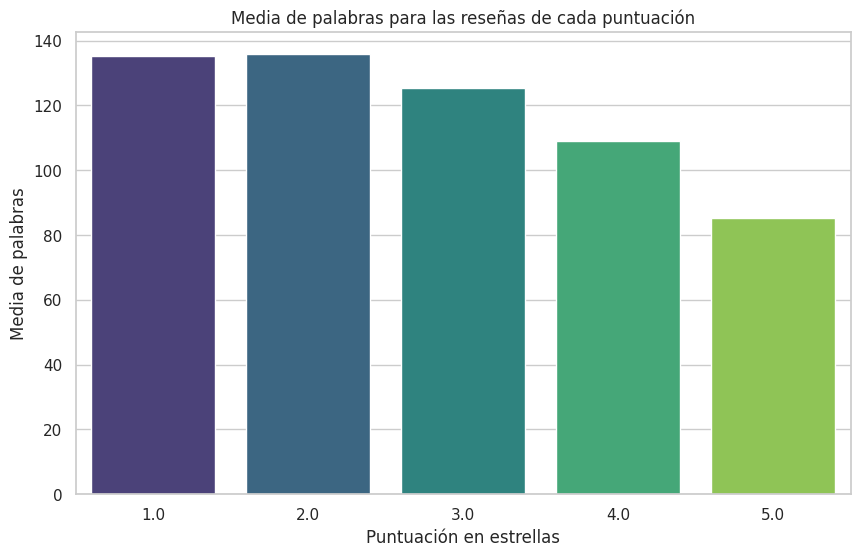

In [10]:
avg_words_by_stars_pd = avg_words_by_stars.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="stars", y="avg_words", data=avg_words_by_stars_pd, palette="viridis")
plt.title("Media de palabras para las reseñas de cada puntuación")
plt.xlabel("Puntuación en estrellas")
plt.ylabel("Media de palabras")
plt.show()

##### 5. Obtener las 10 categorías que más se repiten para cada puntuación (1-5 estrellas) (4%)


In [11]:
df_review = df_review.withColumnRenamed("stars", "review_stars")

windowSpec = Window.partitionBy("review_stars").orderBy(col("count").desc())
result5 = (
    df_review
    .join(df_business, "business_id")
    .select("review_stars", explode(split("categories", ", ")).alias("category"))
    .groupBy("review_stars", "category")
    .agg(count("*").alias("count"))
    .withColumn("row_number", row_number().over(windowSpec))
    .filter(col("row_number") <= 10)
    .drop("row_number")
    .orderBy("review_stars", col("count").desc())
)

result5.show(500)

+------------+--------------------+-------+
|review_stars|            category|  count|
+------------+--------------------+-------+
|         1.0|         Restaurants| 567185|
|         1.0|                Food| 200062|
|         1.0|           Nightlife| 171310|
|         1.0|                Bars| 160744|
|         1.0|American (Traditi...| 135761|
|         1.0|            Shopping| 110161|
|         1.0|      American (New)|  98740|
|         1.0|Event Planning & ...|  91701|
|         1.0|  Breakfast & Brunch|  89419|
|         1.0|             Burgers|  81299|
|         2.0|         Restaurants| 404486|
|         2.0|                Food| 135015|
|         2.0|           Nightlife| 134947|
|         2.0|                Bars| 128301|
|         2.0|American (Traditi...|  98551|
|         2.0|      American (New)|  85894|
|         2.0|  Breakfast & Brunch|  69261|
|         2.0|          Sandwiches|  55881|
|         2.0|Event Planning & ...|  54730|
|         2.0|             Seafo

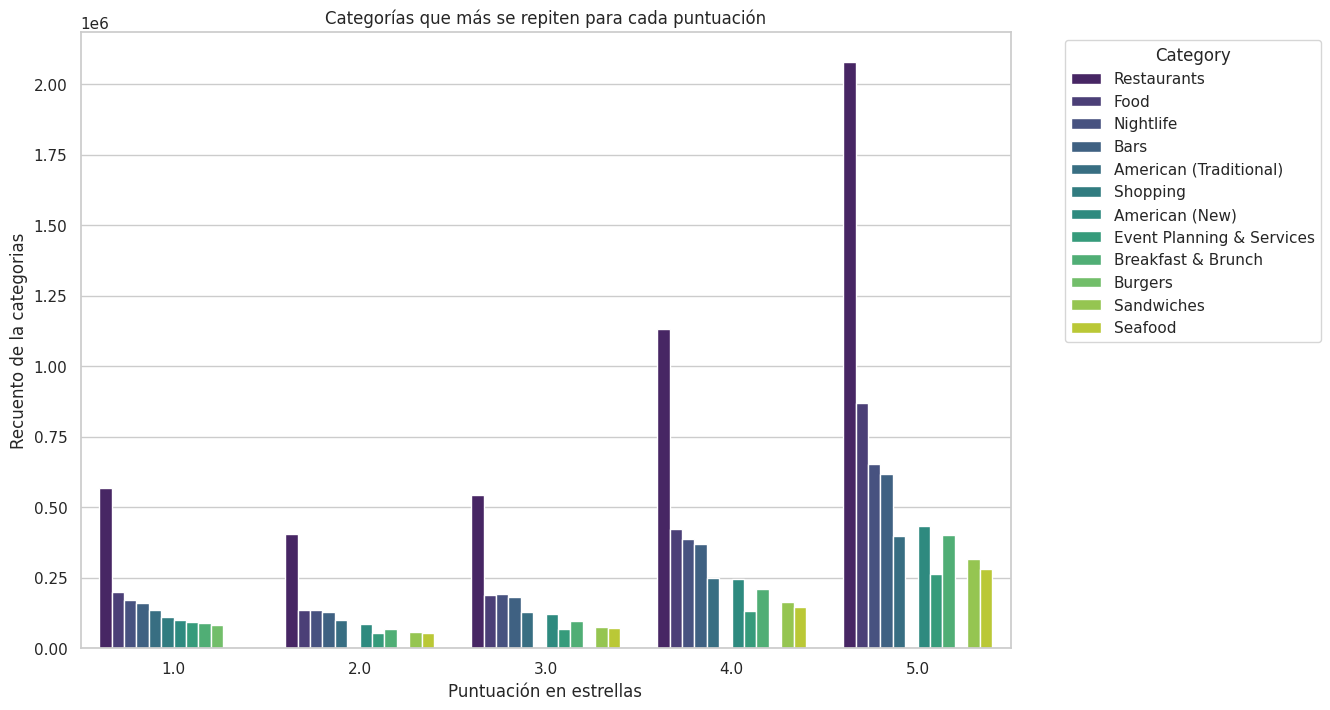

In [12]:
top_categories_pd = result5.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras apiladas utilizando Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x="review_stars", y="count", hue="category", data=top_categories_pd, palette="viridis")
plt.title("Categorías que más se repiten para cada puntuación")
plt.xlabel("Puntuación en estrellas")
plt.ylabel("Recuento de la categorias")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/tmp/ipykernel_13617/957464628.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_13617/957464628.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


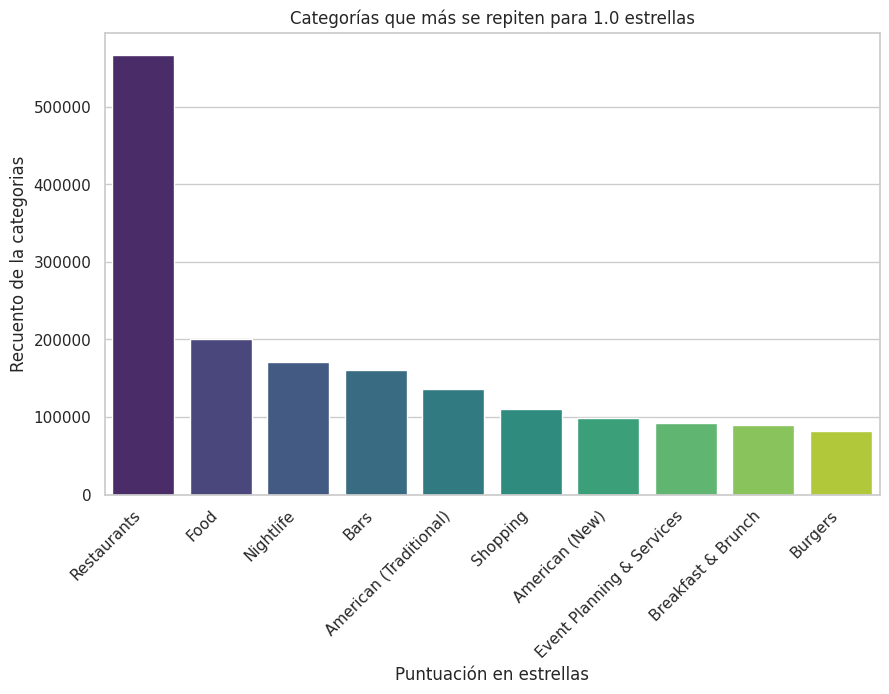

/tmp/ipykernel_13617/957464628.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_13617/957464628.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


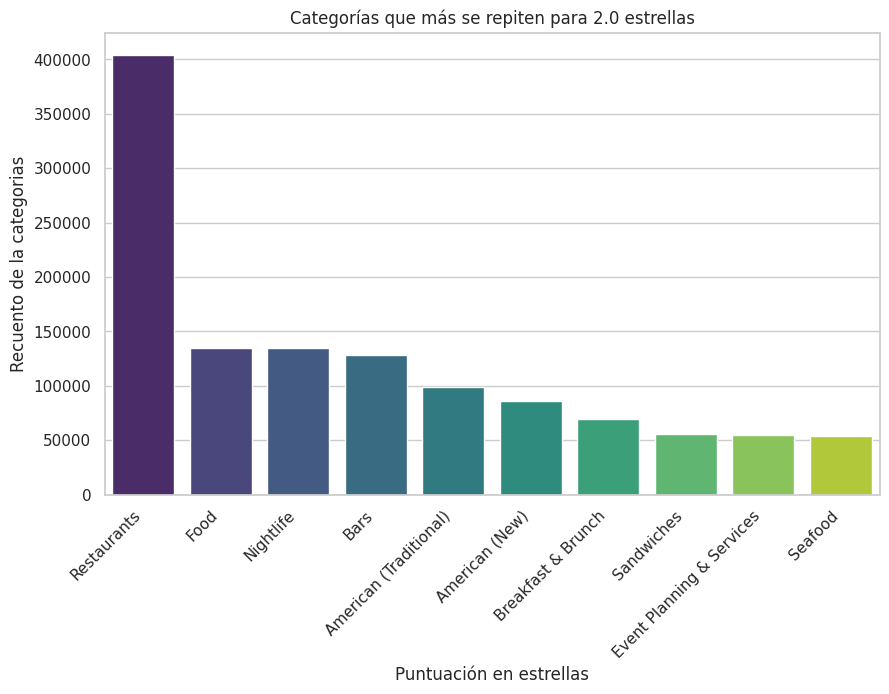

/tmp/ipykernel_13617/957464628.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_13617/957464628.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


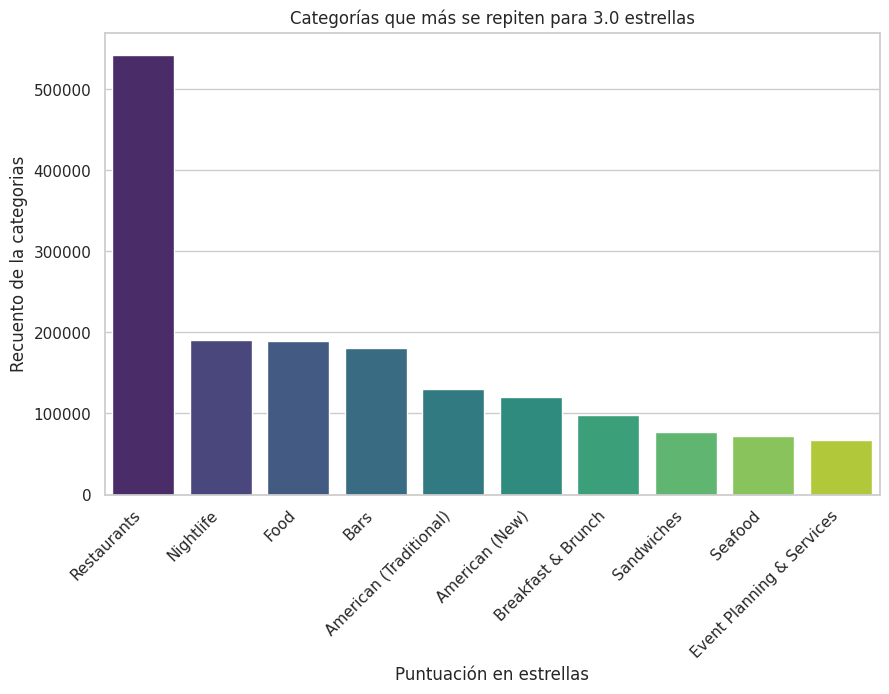

/tmp/ipykernel_13617/957464628.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_13617/957464628.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


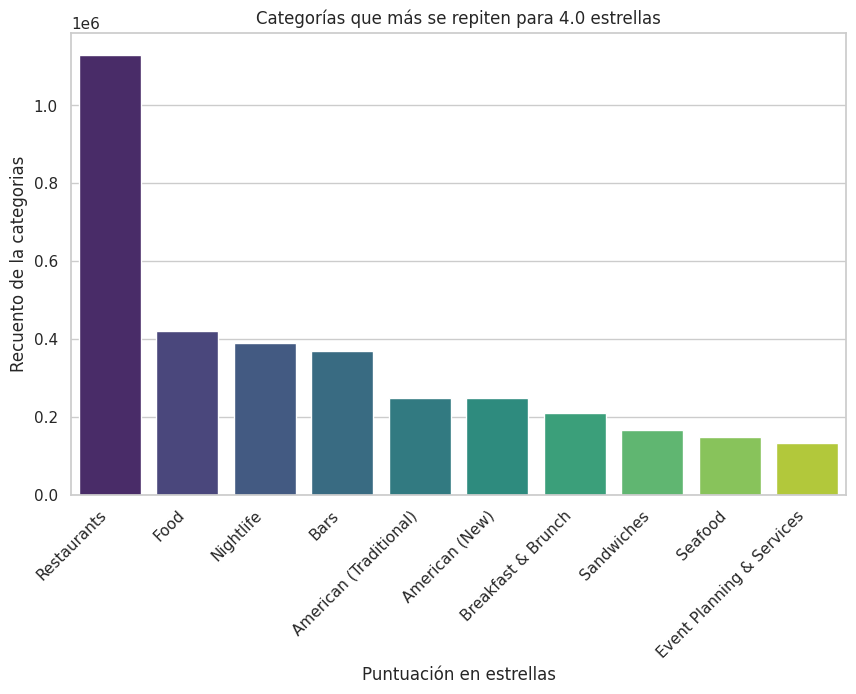

/tmp/ipykernel_13617/957464628.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
/tmp/ipykernel_13617/957464628.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)


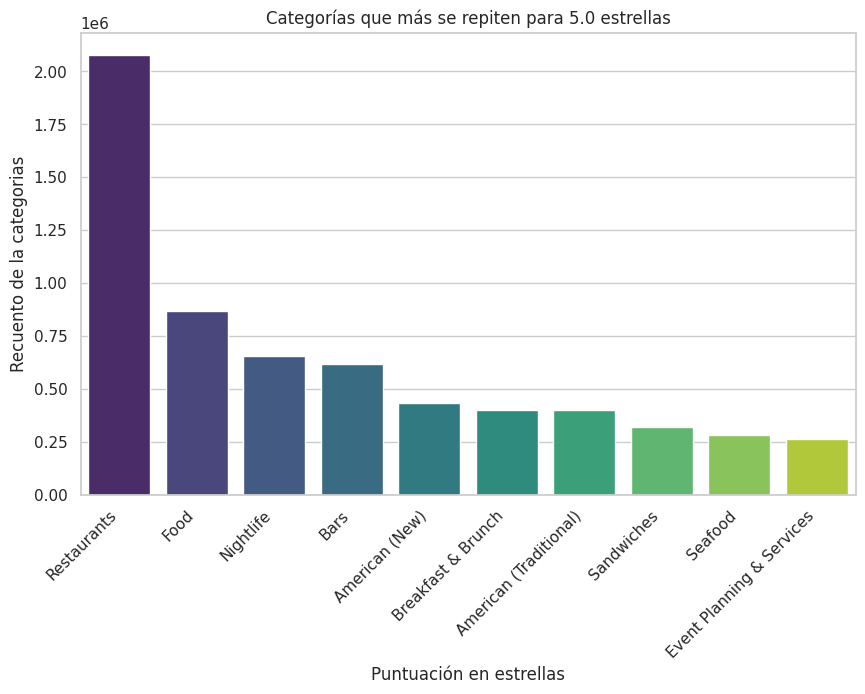

In [13]:
top_categories_pd = result5.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras apiladas para cada valor de puntuación
for star_value in top_categories_pd['review_stars'].unique():
    plt.figure(figsize=(10, 6))
    subset_df = top_categories_pd[top_categories_pd['review_stars'] == star_value]
    sns.barplot(x="category", y="count", data=subset_df, palette="viridis", ci=None)
    plt.title(f"Categorías que más se repiten para {star_value} estrellas")
    plt.xlabel("Puntuación en estrellas")
    plt.ylabel("Recuento de la categorias")
    plt.xticks(rotation=45, ha="right")
    plt.show()

##### 6. Analizar cómo un atributo determinado afecta a la puntuación del negocio (4%)


In [14]:
#  Se refiere al campo "atributo" o a uyna columna cualqueira

attribute_effect = df_business.select("stars", "attributes.ByAppointmentOnly") \
    .groupBy("ByAppointmentOnly").agg(avg("stars").alias("avg_stars"))

result6 = attribute_effect.show()


+-----------------+------------------+
|ByAppointmentOnly|         avg_stars|
+-----------------+------------------+
|             None|              3.45|
|            False|3.7063694267515923|
|             null|3.5178923588285946|
|             True|3.9550900121724646|
+-----------------+------------------+



/tmp/ipykernel_13617/885905411.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ByAppointmentOnly", y="avg_stars", data=attribute_effect_pd, palette="viridis")


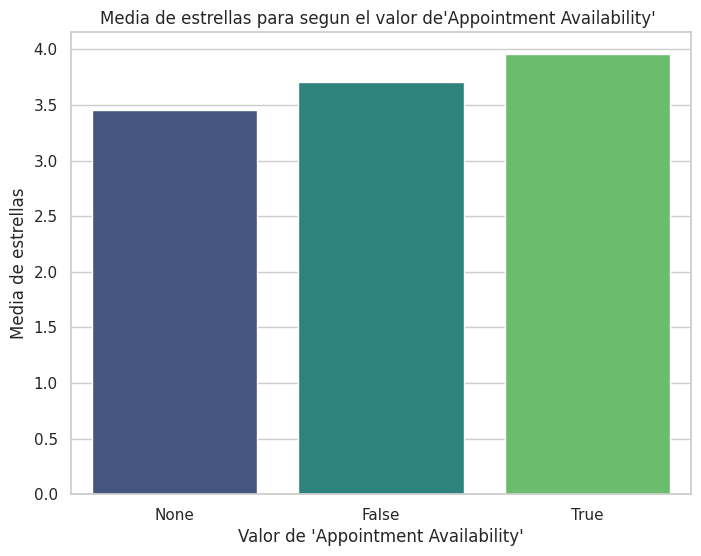

In [30]:
attribute_effect_pd = attribute_effect.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de barras utilizando Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x="ByAppointmentOnly", y="avg_stars", data=attribute_effect_pd, palette="viridis")
plt.title("Media de estrellas para segun el valor de'Appointment Availability' ")
plt.xlabel("Valor de 'Appointment Availability'")
plt.ylabel("Media de estrellas")
plt.show()

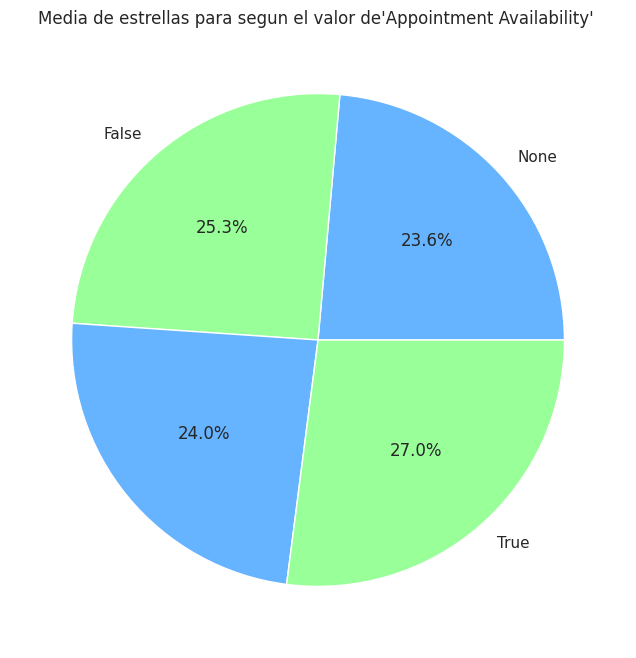

In [29]:
attribute_effect_pd = attribute_effect.toPandas()

# Crear un gráfico de quesos utilizando Matplotlib
plt.figure(figsize=(8, 8))
plt.pie(attribute_effect_pd['avg_stars'], labels=attribute_effect_pd['ByAppointmentOnly'], autopct='%1.1f%%', colors=['#66b3ff','#99ff99'])
plt.title("Media de estrellas para segun el valor de'Appointment Availability' ")
plt.show()

In [57]:
df_business.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   address                150346 non-null  object 
 1   attributes             136602 non-null  object 
 2   business_id            150346 non-null  object 
 3   categories             150243 non-null  object 
 4   city                   150346 non-null  object 
 5   hours                  127123 non-null  object 
 6   is_open                150346 non-null  int64  
 7   latitude               150346 non-null  float64
 8   longitude              150346 non-null  float64
 9   name                   150346 non-null  object 
 10  postal_code            150346 non-null  object 
 11  review_count           150346 non-null  int64  
 12  stars                  150346 non-null  float32
 13  state                  150346 non-null  object 
 14  review_count_interval  150346 non-nu

In [73]:
# Agregar la columna "review_count_interval" al DataFrame
df_business = df_business.withColumn("review_count_interval", (floor(df_business["review_count"] / 100) * 100).cast("int")).orderBy(col("review_count_interval"))

# Calcular la media y la suma de puntuación para cada intervalo de review_count
result6 = df_business.groupBy("review_count_interval").agg(
    mean("stars").alias("media_puntuacion"),
    count("review_count_interval").alias("total_reviews")
)

# Mostrar el resultado
result6.show(4400)

+---------------------+------------------+-------------+
|review_count_interval|  media_puntuacion|total_reviews|
+---------------------+------------------+-------------+
|                    0| 3.573928326664161|       135699|
|                  100|3.7463414634146344|         8405|
|                  200|3.8403886190145733|         2882|
|                  300|3.8866017964071857|         1336|
|                  400|3.9208955223880597|          670|
|                  500| 3.945475638051044|          431|
|                  600| 3.973469387755102|          245|
|                  700|  3.92090395480226|          177|
|                  800|               4.0|          105|
|                  900|4.0246913580246915|           81|
|                 1000| 4.088888888888889|           45|
|                 1100| 4.060975609756097|           41|
|                 1200| 4.111111111111111|           36|
|                 1300| 4.103448275862069|           29|
|                 1400| 4.17391

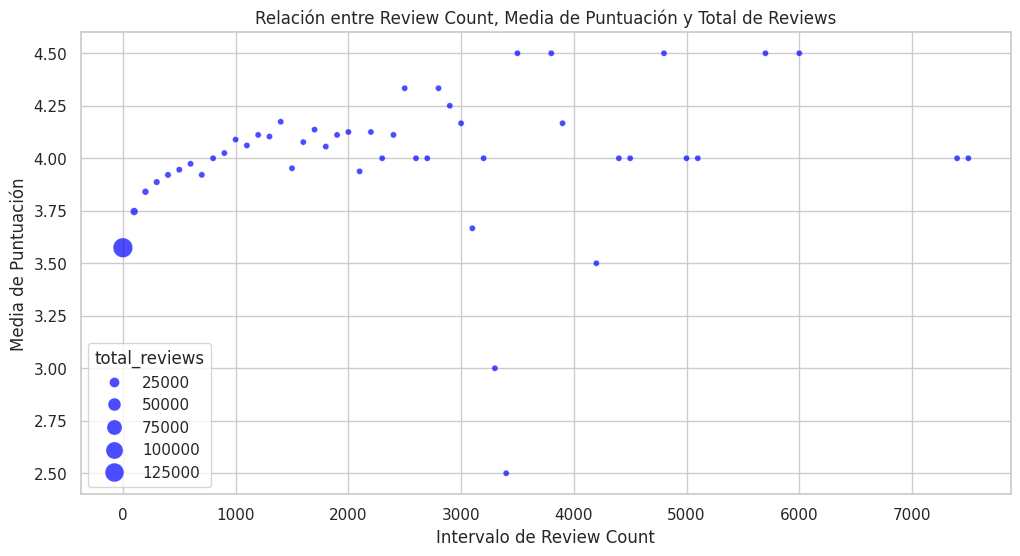

In [74]:
# Convertir los resultados a Pandas DataFrame para Seaborn
result_pd = result6.toPandas()

# Crear el gráfico de dispersión utilizando Seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(x="review_count_interval", y="media_puntuacion", size="total_reviews", sizes=(20, 200), data=result_pd, color="blue", alpha=0.7)
plt.title("Relación entre Review Count, Media de Puntuación y Total de Reviews")
plt.xlabel("Intervalo de Review Count")
plt.ylabel("Media de Puntuación")
plt.show()

##### 7. Obtener la media anual de puntuación para las 10 categorías con mayor número de reseñas (4%)

In [75]:
# Obtener las 10 categorías con mayor número de reseñas
top_categories_by_reviews = (
    df_review
    .join(df_business, "business_id")
    .select(explode(split("categories", ", ")).alias("category"))
    .groupBy("category")
    .agg(count("*").alias("num_reviews"))
    .orderBy(col("num_reviews").desc())
    .limit(10)
)

# Renombrar la columna "stars" de df_review a "review_stars"
df_review = df_review.withColumnRenamed("stars", "review_stars")

# Filtrar las reseñas para las categorías seleccionadas
filtered_reviews = (
    df_review
    .join(df_business, "business_id")
    .select("review_stars", "date", explode(split("categories", ", ")).alias("category"))
    .join(top_categories_by_reviews, "category")
)

# Agregar una columna de año y calcular la media anual de puntuación para las 10 categorías con mayor número de reseñas
windowSpec = Window.partitionBy("category", "year").orderBy("year")

result = (
    filtered_reviews
    .withColumn("year", year("date"))
    .groupBy("category", "year")
    .agg(avg(col("review_stars")).alias("avg_stars"))
    .withColumn("row_number", row_number().over(windowSpec))
    .filter(col("row_number") == 1)
    .drop("row_number")
    .orderBy("category", "year")
)

result.show(400)

+--------------------+----+------------------+
|            category|year|         avg_stars|
+--------------------+----+------------------+
|      American (New)|2005| 4.086956521739131|
|      American (New)|2006|  4.05607476635514|
|      American (New)|2007| 3.885222381635581|
|      American (New)|2008| 3.790946896992962|
|      American (New)|2009| 3.693454925429847|
|      American (New)|2010| 3.714959175738725|
|      American (New)|2011|3.7084460042575227|
|      American (New)|2012| 3.705262675766042|
|      American (New)|2013| 3.708643879037094|
|      American (New)|2014|3.7905753274017795|
|      American (New)|2015|3.8261306721544086|
|      American (New)|2016| 3.854635336531896|
|      American (New)|2017|3.8659174072138005|
|      American (New)|2018| 3.887391530984577|
|      American (New)|2019|3.8899515208575934|
|      American (New)|2020| 3.967351756925017|
|      American (New)|2021| 3.894207115460918|
|      American (New)|2022|3.9226490066225166|
|American (Tr

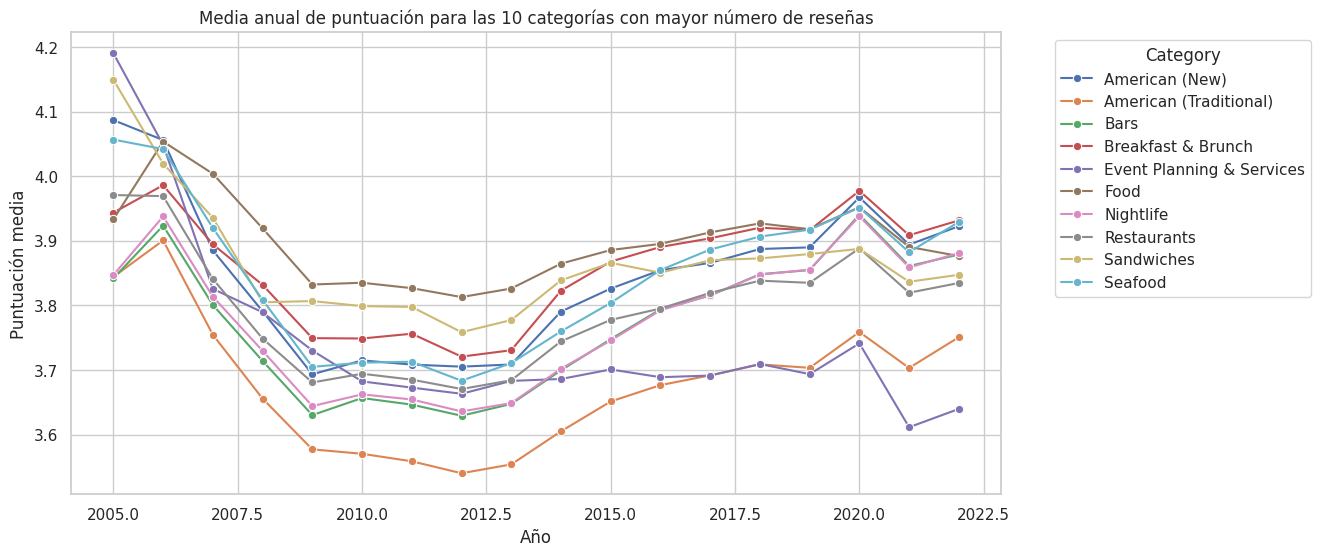

In [76]:
result_pd = result.toPandas()

# Configurar el estilo de Seaborn (opcional)
sns.set(style="whitegrid")

# Crear un gráfico de líneas utilizando Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x="year", y="avg_stars", hue="category", data=result_pd, marker="o")
plt.title("Media anual de puntuación para las 10 categorías con mayor número de reseñas")
plt.xlabel("Año")
plt.ylabel("Puntuación media")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()